<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0/blob/master/14_RCNN/03_DepthModel_DataViz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Model - Data Visualization

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/DepthProject

/content/gdrive/My Drive/DepthProject


In [3]:
ls -l

total 5225848
drwx------ 2 root root       4096 May  3 15:54 DenseDepth/
-rw------- 1 root root    1706380 May  3 15:22 depth_dataset_cleaned_raw.zip
-rw------- 1 root root 2286492537 May  3 14:31 depth_dataset_cleaned.zip
drwx------ 2 root root       4096 May  4 11:36 depth_dataset_zipped/
-rw------- 1 root root 3063060216 May  5 23:11 depth_fg_bg.zip


In [4]:
from zipfile import ZipFile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from PIL import Image
import torchvision.transforms as T
import os
import torch
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Create the Dataset

In [0]:
class DenseDepth(Dataset):
    '''
    DenseDepth Dataset

    Input is fg_bg image AND bg image
    Target is fg_bg_mask AND depth_fg_bg image
    '''
    def __init__(self, root, data='fg_bg', train=True, transform=None, target_transform=None, download=False):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        self.data = data


        if self.data == 'fg_bg':
            fg_bg_zip =  ZipFile(os.path.join(self.root,'depth_dataset_zipped/fg_bg.zip'), 'r') # fg_bg
            fg_bg_paths = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]
            self.image_zip = fg_bg_zip
            self.image_paths = fg_bg_paths
        elif self.data == 'bg':
            bg_zip = ZipFile(os.path.join(self.root,'depth_dataset_zipped/bg.zip'), 'r') # bg
            bg_paths = [info.filename for info in bg_zip.infolist() if not info.is_dir()]
            self.image_zip = bg_zip
            self.image_paths = bg_paths
        elif self.data == 'fg':
            fg_zip = ZipFile(os.path.join(self.root,'depth_dataset_zipped/fg.zip'), 'r') # fg
            fg_paths = [info.filename for info in fg_zip.infolist() if not info.is_dir()]
            self.image_zip = fg_zip
            self.image_paths = fg_paths
        elif self.data == 'fg_bg_mask':
            fg_bg_mask_zip = ZipFile(os.path.join(self.root,'depth_dataset_zipped/fg_bg_mask.zip'), 'r') # fg_bg_mask
            fg_bg_mask_paths = [info.filename for info in fg_bg_mask_zip.infolist() if not info.is_dir()]
            self.image_zip = fg_bg_mask_zip
            self.image_paths = fg_bg_mask_paths
        elif self.data == 'depth_fg_bg':
            depth_fg_bg_zip =  ZipFile(os.path.join(self.root,'depth_dataset_zipped/depth_fg_bg.zip'), 'r') # target
            depth_fg_bg_paths = [info.filename for info in depth_fg_bg_zip.infolist() if not info.is_dir()]
            self.image_zip = depth_fg_bg_zip
            self.image_paths = depth_fg_bg_paths
        else:
            raise f'{data} is not a valid option'


    def __getitem__(self, index):
        imgdata = self.image_zip.read(self.image_paths[index])
        img = Image.open(io.BytesIO(imgdata))

        if self.data == 'depth_fg_bg':
            img = img.convert('L')
        elif self.data == 'fg':
            width, height = img.size

            bigside = width if width > height else height

            background = Image.new('RGBA', (bigside, bigside), (255, 0, 0, 0))
            offset = (int(round(((bigside - width) / 2), 0)), int(round(((bigside - height) / 2),0)))

            background.paste(img, offset)
            img = background
            img = img.resize((200, 200), Image.ANTIALIAS)
        else:
            img = img.convert("RGB")

        img = np.array(img)

        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        return len(self.image_paths)

In [0]:
def plot_images_horizontally(images):
    fig = plt.figure(figsize=(50, 40))
    num_imgs = images.shape[0]
    for i in range(num_imgs):
        fig.add_subplot(1, num_imgs, i + 1)

        # render image tensor
        img = images[i]
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))

        plt.imshow(npimg)
        plt.axis('off')

# Foreground Images

In [0]:
bg_dataset = DenseDepth(root='./', data='fg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [150]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 4, 200, 200])

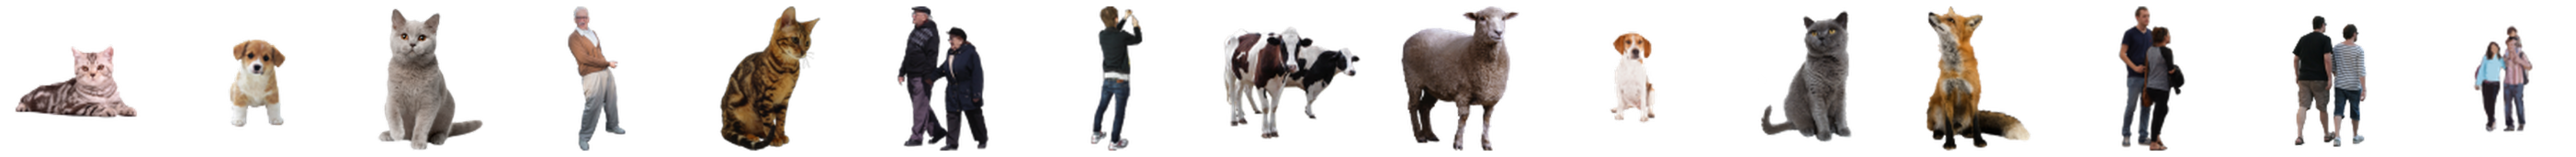

In [151]:
plot_images_horizontally(images)

# Background Images

In [0]:
bg_dataset = DenseDepth(root='./', data='bg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [48]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 3, 200, 200])

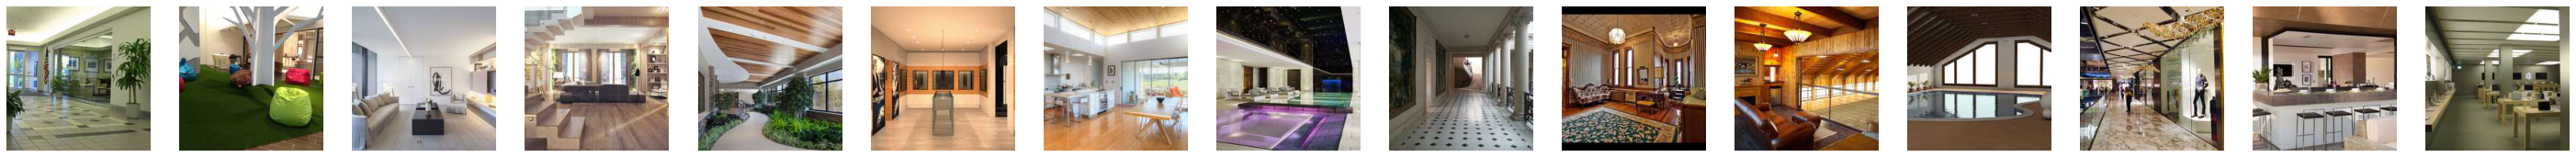

In [57]:
plot_images_horizontally(images)

# Foreground Background Images

In [0]:
bg_dataset = DenseDepth(root='./', data='fg_bg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [59]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 3, 200, 200])

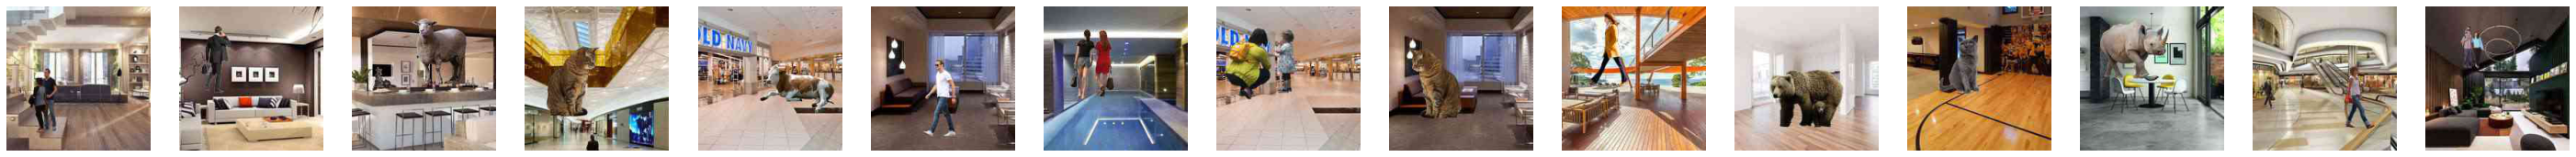

In [60]:
plot_images_horizontally(images)

# Foreground Background Mask Images

In [0]:
bg_dataset = DenseDepth(root='./', data='fg_bg_mask', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [62]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 3, 200, 200])

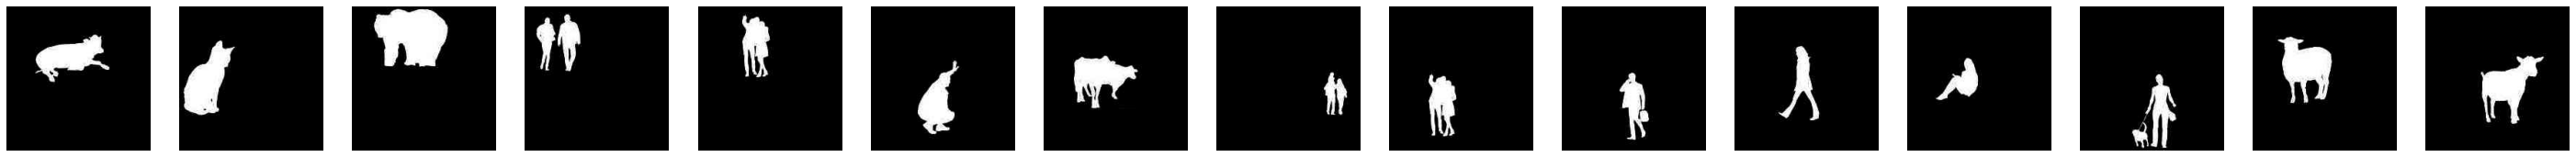

In [63]:
plot_images_horizontally(images)

# Foreground Backgroud Depth Images

In [0]:
bg_dataset = DenseDepth(root='./', data='depth_fg_bg', transform=T.Compose([T.ToTensor()]))
dataloader = torch.utils.data.DataLoader(bg_dataset, batch_size=15, shuffle=True, num_workers=1)

In [65]:
images = next(iter(dataloader))
images.shape

torch.Size([15, 1, 200, 200])

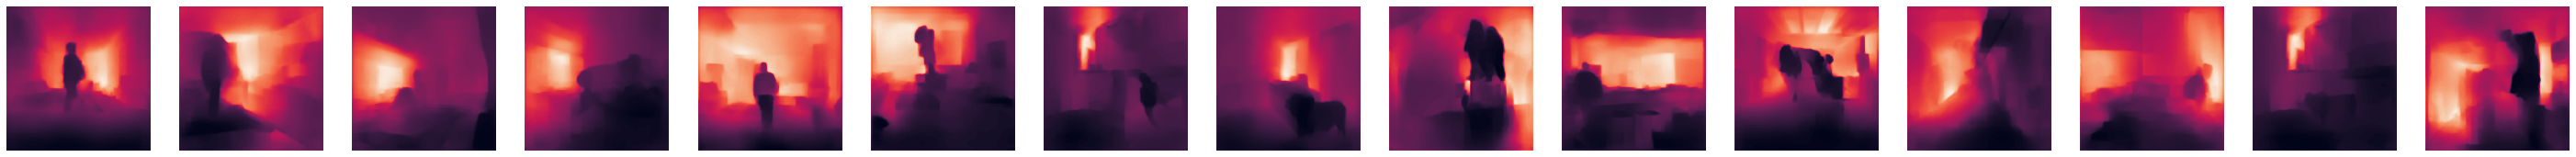

In [74]:
fig = plt.figure(figsize=(50, 40))
num_imgs = images.shape[0]
for i in range(num_imgs):
    fig.add_subplot(1, num_imgs, i + 1)

    # render image tensor
    img = images[i][0]
    npimg = img.numpy()
    
    plt.imshow(npimg)
    plt.axis('off')